In [1]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import glob
import os
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import random
import soundfile as sf

# Construct Dataset of *Boana faber* Recordings

This notebook constructs one-second recording clips of *Boana faber* calls.

In [ ]:
df = pd.read_csv('../../../Grabaciones curadas/data_catalog.csv')
df = df.query("rana_label == 'BOAFAB' and quality_label == 'C'") # Only use BOAFAB calls with quality C (Clear)

# Create the folder if it doesn't exist
os.makedirs("../../data/train_gen/BOAFAB/", exist_ok=True)

In [ ]:
'''
Auxiliar functions to load and manipulate audio data
'''
def load_audio(obs, verbose=False):
    '''
    Load audio from a given observation
    
    Parameters:
    obs (pd.Series): observation to load audio from

    Returns:
    audio (np.array): audio array
    sr (int): sample rate
    '''
    wav_path = obs.file_wav
    audio, sr = librosa.load(f'../../Grabaciones curadas/Grabaciones curadas/{wav_path}', sr=16_000)
    if verbose:
        print(obs)

    return audio, sr

def truncate_audio(audio, slice_1, slice_2):
    '''
    Truncate audio array

    Parameters:
    audio (np.array): audio array
    slice_1 (int): start index
    slice_2 (int): end index

    Returns:
    new_audio (np.array): truncated audio array.
    '''
    new_audio = audio[slice_1:slice_2]

    return new_audio

def make_plot(audio_array, sample_rate):
    '''
    Make a plot of the audio array and its spectrogram

    Parameters:
    audio_array (np.array): audio array
    sample_rate (int): sample rate
    '''

    plt.figure().set_figwidth(14)
    librosa.display.waveshow(audio_array, sr=sample_rate)

    ## Espectograma
    D = librosa.stft(audio_array)
    # Convert the complex-valued result to magnitude
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    # Display the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma de Frecuencia Real')
    plt.show()

def get_completation(audio, init_sec, end_sec, sr, samples=1):
    '''
    Get samples of audio with completation of the audio
    
    Parameters:
    audio (np.array): audio array
    init_sec (int): initial second to truncate
    end_sec (int): final second to truncate
    sr (int): sample rate
    samples (int): number of samples to generate

    Returns:
    res (dict): dictionary with the samples generated
    '''

    slice_1 = int(init_sec * sr); slice_2 = int(end_sec * sr)

    n_to_sec = sr - (slice_2 - slice_1)
    index_to_roll = [i for i in range(n_to_sec) if i < slice_1]
    random.shuffle(index_to_roll)
    
    res = {}
    for i in range(samples):
        try:
            left_index = index_to_roll.pop()
        except:
            break
        try:
            slice_1_temp = slice_1 - left_index
            right_index = n_to_sec - left_index
            slice_2_temp = slice_2 + right_index
            sample_audio = truncate_audio(audio, slice_1_temp, slice_2_temp)
            res[i] = sample_audio
        except:
            continue

    return res


def save_audios(dict_audios, sr, audio_path, mark):
    '''
    Save audios in a given path with a given mark

    Parameters:
    dict_audios (dict): dictionary with the audios to save
    sr (int): sample rate
    audio_path (str): path to save the audios
    mark (str): mark to add to the audios
    '''

    for key in dict_audios:
        audio = dict_audios[key]
        
        new_path = f'{mark}_{key}_{audio_path}'
        
        sf.write(f'../../data/train_gen/BOAFAB/{new_path}', audio, sr)

## Process of recording with lenght below or equal to one second

We extend the audio clip to one second using original recording where the annotation exist. Any remaining space to reach the one-second length is filled with adjacent unsymmetrical tails in the original audio. The process also serves as data augmentation, allowing us to get multiple training examples from a single annotated audio.

c:\Users\snung\miniconda3\envs\myenv\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1528
  warnings.warn(


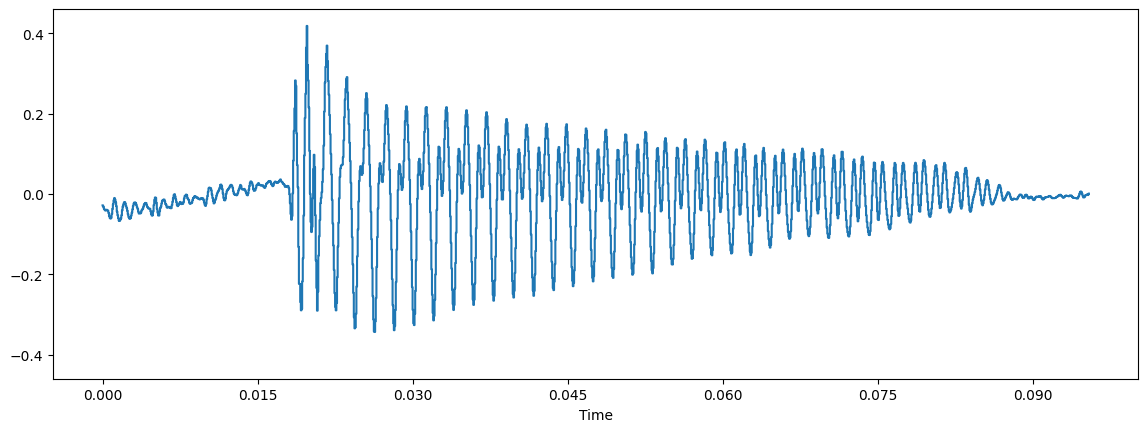

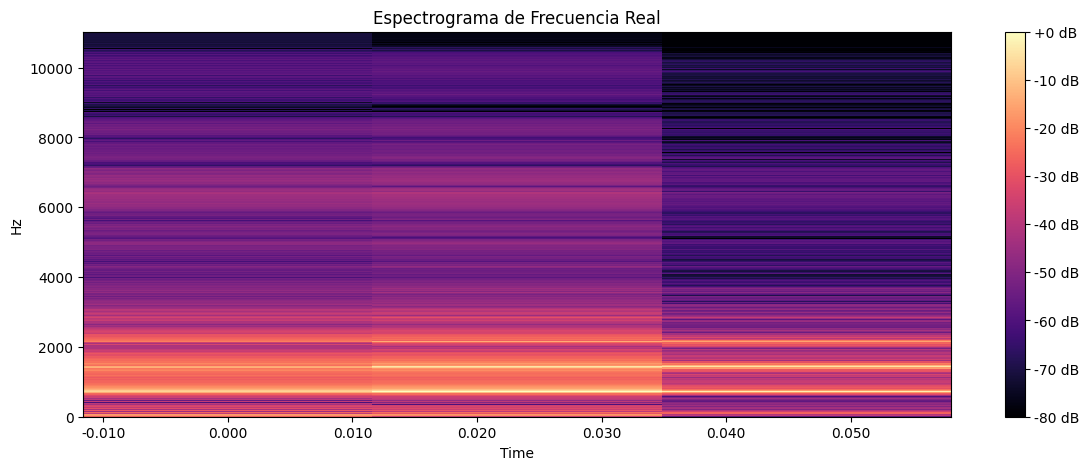

In [5]:
''' Example of how to use the functions and the completation of the audio '''
df_leq_one_sec = df.loc[df.length <= 1]
obs = df_leq_one_sec.loc[3938]
audio, sr = load_audio(obs)
slice_1 = int(obs.init * sr); slice_2 = int(obs.end * sr)

new_audio = truncate_audio(audio, slice_1, slice_2)
make_plot(new_audio, sr)
Audio(data=new_audio, rate=sr)                

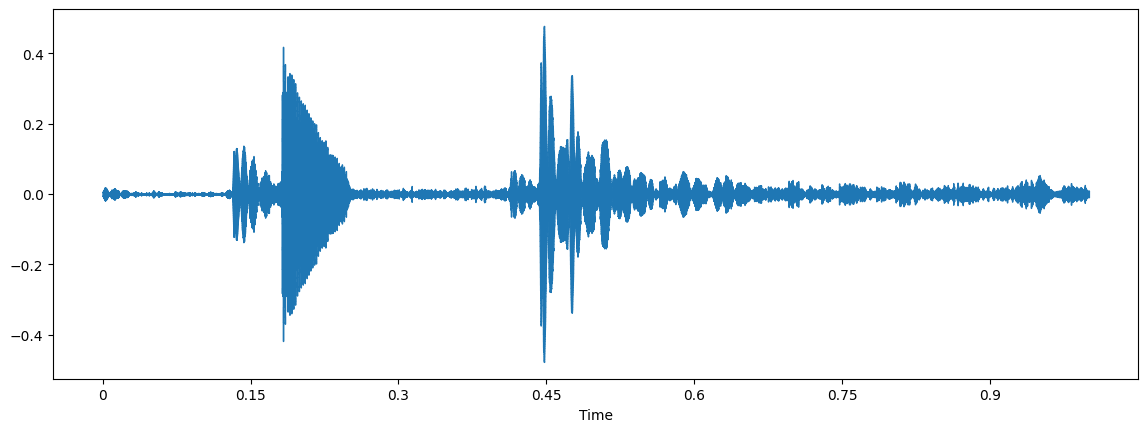

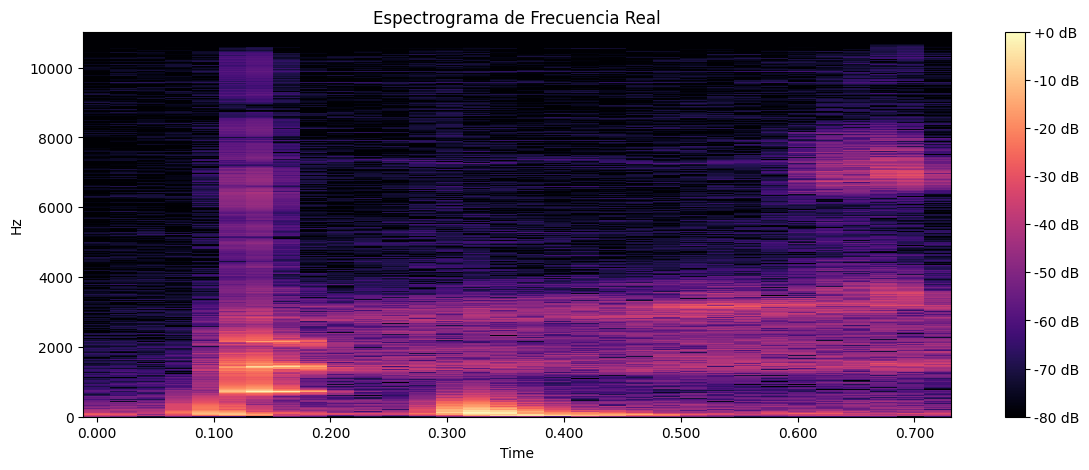

In [28]:
''' Example of 100 compleations of the audio '''
res = get_completation(audio, obs.init, obs.end, sr, 100)
new_audio = res[2]
make_plot(new_audio, sr)
Audio(data=new_audio, rate=sr)

### First data construction  (11.700)

In [6]:
''' for each observation in the dataframe, generate 100 completations of the audio '''

for i, obs in tqdm(df_leq_one_sec.iterrows()):
    audio, sr = load_audio(obs)
    res = get_completation(audio, obs.init, obs.end, sr, 100)
    save_audios(res, sr, obs.file_wav, i)

117it [03:12,  1.64s/it]


## Precess audios of lenght above one second

We apply a rolling window to extract one-second clips from the audio. The window is positioned to ensure that contains some part of the annotated clip. The window starts 0.5 seconds before the annotation’s initial time and move forward until its end position exceeds the annotation’s final time

In [7]:
def get_all_secs(audio, init, end, sr):
    '''
    Get all the seconds of the audio between init and end

    Parameters:
    audio (np.array): audio array
    init (int): initial second
    end (int): final second
    sr (int): sample rate

    Returns:
    res (dict): dictionary with the samples generated
    '''

    # rolling overlaping window
    slice_1 = int(init * sr); slice_2 = int(end * sr)

    center = slice_1
    i = 0
    res = {}
    while center <= slice_2:
        slice_1_temp = int(center - (sr // 2))
        slice_2_temp = int(center + (sr // 2))
        if slice_1_temp < 0:
            center = slice_2_temp
            continue

        sample_audio = truncate_audio(audio, slice_1_temp, slice_2_temp)
        res[i] = sample_audio

        center = slice_2_temp
        i += 1

    return res

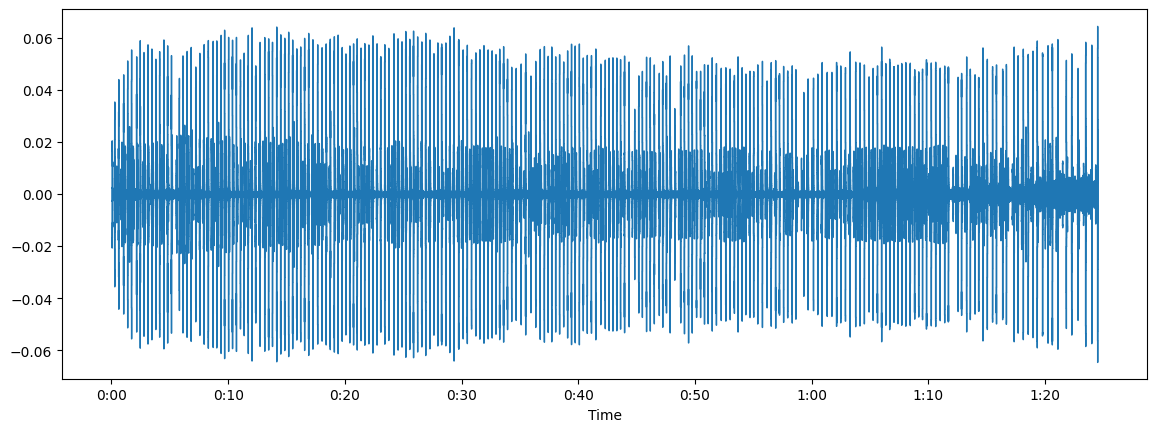

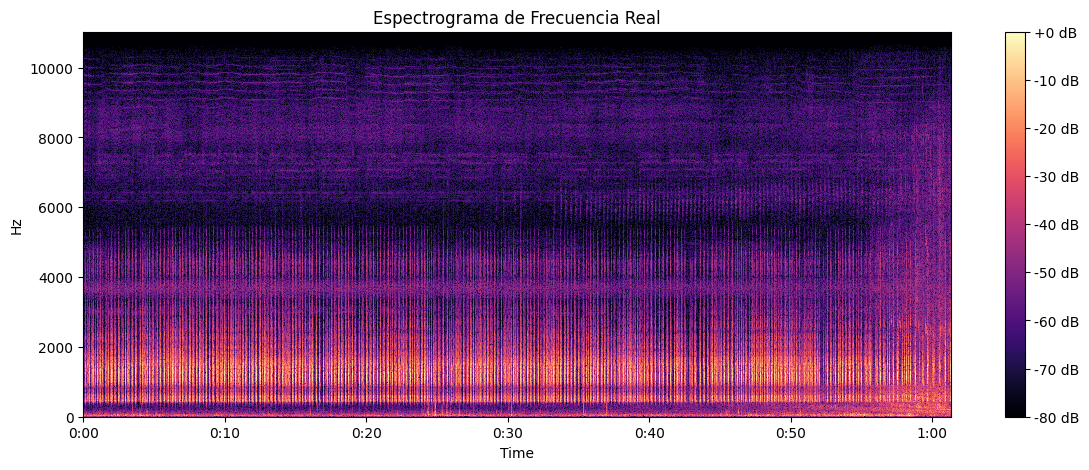

In [9]:
''' Example of how to use the function to get all the seconds of the audio '''
df_geq_one_sec = df.loc[df.length > 1]
obs = df_geq_one_sec.loc[2876]
audio, sr = load_audio(obs)
slice_1 = int(obs.init * sr); slice_2 = int(obs.end * sr)

new_audio = truncate_audio(audio, slice_1, slice_2)
make_plot(new_audio, sr)
Audio(data=new_audio, rate=sr)         

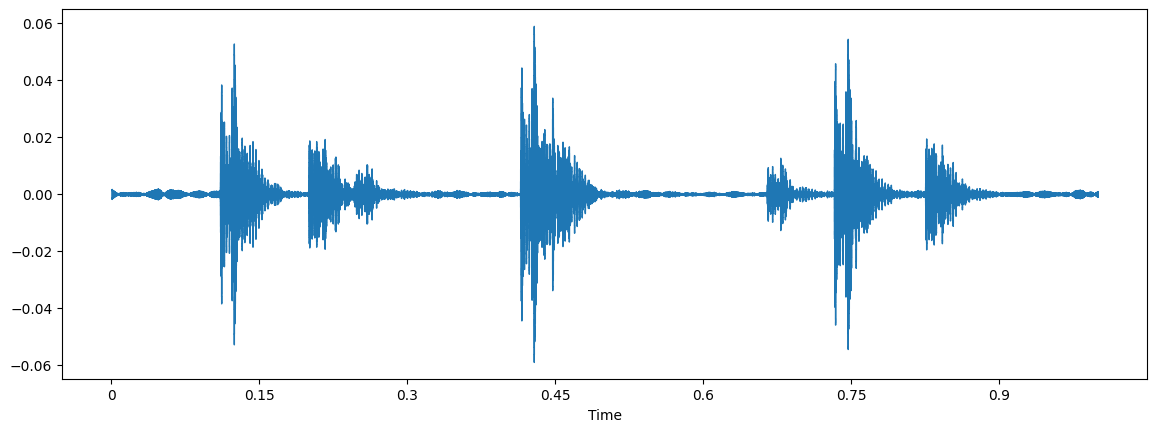

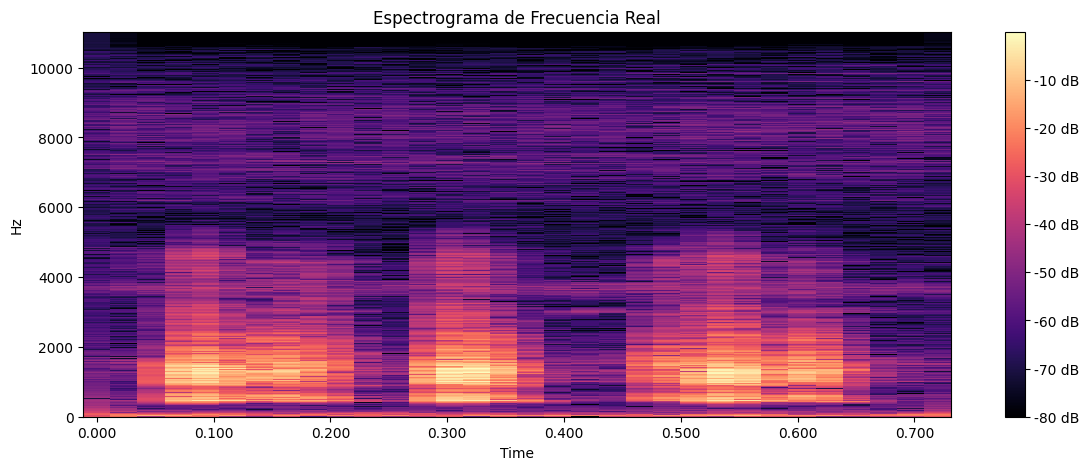

In [10]:
''' Example of all the seconds of the audio '''
res = get_all_secs(audio, obs.init, obs.end, sr)
new_audio = res[4]
make_plot(new_audio, sr)
Audio(data=new_audio, rate=sr)

### Second data construction (2.957)

In [11]:
''' for each observation in the dataframe, generate all the seconds of the audio '''
for i, obs in tqdm(df_geq_one_sec.iterrows()):
    audio, sr = load_audio(obs)
    res = get_all_secs(audio, obs.init, obs.end, sr)
    save_audios(res, sr, obs.file_wav, i)

54it [01:11,  1.32s/it]
